In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import keras

print("Keras version:", keras.__version__)

Keras version: 3.10.0


In [3]:
from typing import Literal


def get_running_environment() -> Literal['local', 'colab', 'kaggle', 'marimo', 'jupyter']:
    """
    Returns the current running environment.
    """
    if 'COLAB_GPU' in os.environ:
        return 'colab'
    elif 'KAGGLE_URL_BASE' in os.environ:
        return 'kaggle'
    elif 'MARIMO' in os.environ:
        return 'marimo'
    elif 'JUPYTERHUB_USER' in os.environ:
        return 'jupyter'
    else:
        return 'local'
current_env = get_running_environment()

def get_data_path(running_env: str) -> str:
    """
    Returns the path to the data directory based on the running environment.
    """
    if running_env == 'colab':
        return '/content/data'
    elif running_env == 'kaggle':
        return '/kaggle/input/histopathologic-cancer-detection'
    elif running_env == 'marimo':
        return '/data'
    else:
        # return './data/histopathologic-cancer-detection'
        return './data'
    
def set_random_seed(seed: int = 42):
    """
    Sets the random seed for reproducibility.
    """
    np.random.seed(seed)
    tf.random.set_seed(seed)
    print(f"Random seed set to {seed}")

data_dir = get_data_path(current_env)
print(f"Data path: {data_dir} (for {current_env} environment)")

RANDOM_SEED = 42

set_random_seed(RANDOM_SEED)

Data path: ./data (for local environment)
Random seed set to 42


In [4]:
IMAGE_SIZE = 96
IMAGE_CHANNEL = 3
SAMPLE_SIZE = 1000
BATCH_SIZE = 32
TRAIN_IMAGE_DIR = os.path.join(data_dir, 'train')
TEST_IMAGE_DIR = os.path.join(data_dir, 'test')

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))

In [6]:
negative_samples = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state=RANDOM_SEED)
positive_samples = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state=RANDOM_SEED)

In [7]:
train_processed_dir = os.path.join(data_dir, "train_processed")
test_processed_dir = os.path.join(data_dir, "test_processed")

In [8]:
train_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=0.2,
    subset="training",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Binary labels (0 or 1)
)

Found 220025 files belonging to 2 classes.
Using 176020 files for training.


2025-07-22 19:28:54.868167: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-07-22 19:28:54.868202: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-22 19:28:54.868211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753205334.868222  261864 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753205334.868237  261864 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
val_ds = image_dataset_from_directory(
    train_processed_dir,
    validation_split=0.2,
    subset="validation",
    seed=RANDOM_SEED,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [10]:
test_ds = image_dataset_from_directory(
    test_processed_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode=None,  # No labels for test
    shuffle=False  # Preserve order for submission
)

Found 57458 files.


2025-07-22 19:29:04.206161: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


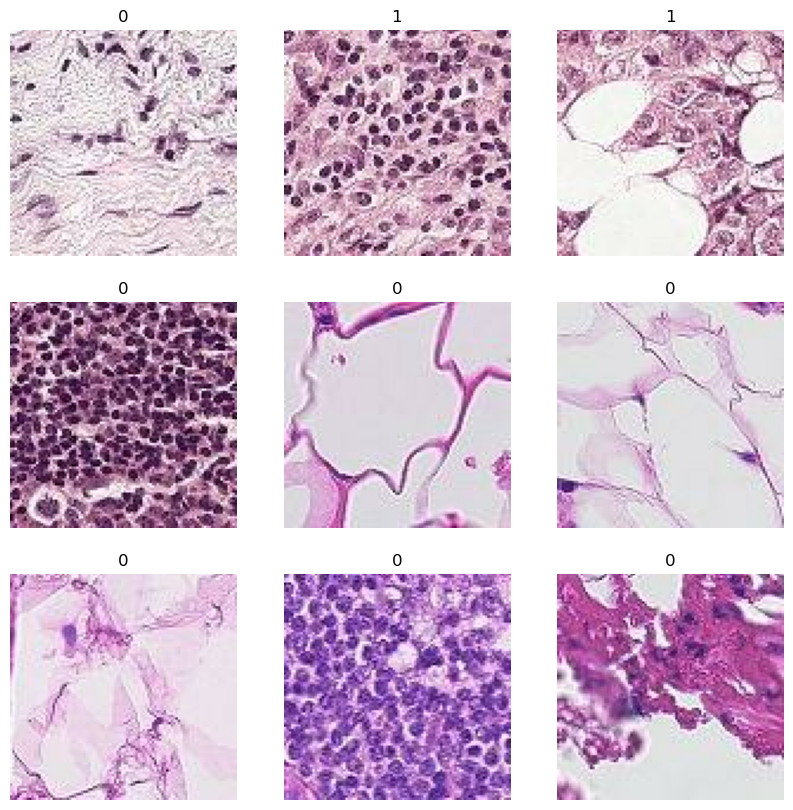

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [12]:
def build_custom_cnn(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = build_custom_cnn(input_shape=(96, 96, 3), num_classes=2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │      3,584 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 48, 48,    │          0 │ activation[0][0]  │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 48, 48,    │     34,176 │ activation_1[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 48, 48,    │     68,096 │ activation_2[0][… │
│ (SeparableConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 24, 24,    │     33,024 │ activation[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 24, 24,    │          0 │ add[0][0]         │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 24, 24,    │    133,888 │ activation_3[0][… │
│ (SeparableConv2D)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │      2,048 │ separable_conv2d

 Total params: 2,731,065 (10.42 MB)

 Trainable params: 2,722,777 (10.39 MB)

 Non-trainable params: 8,288 (32.38 KB)

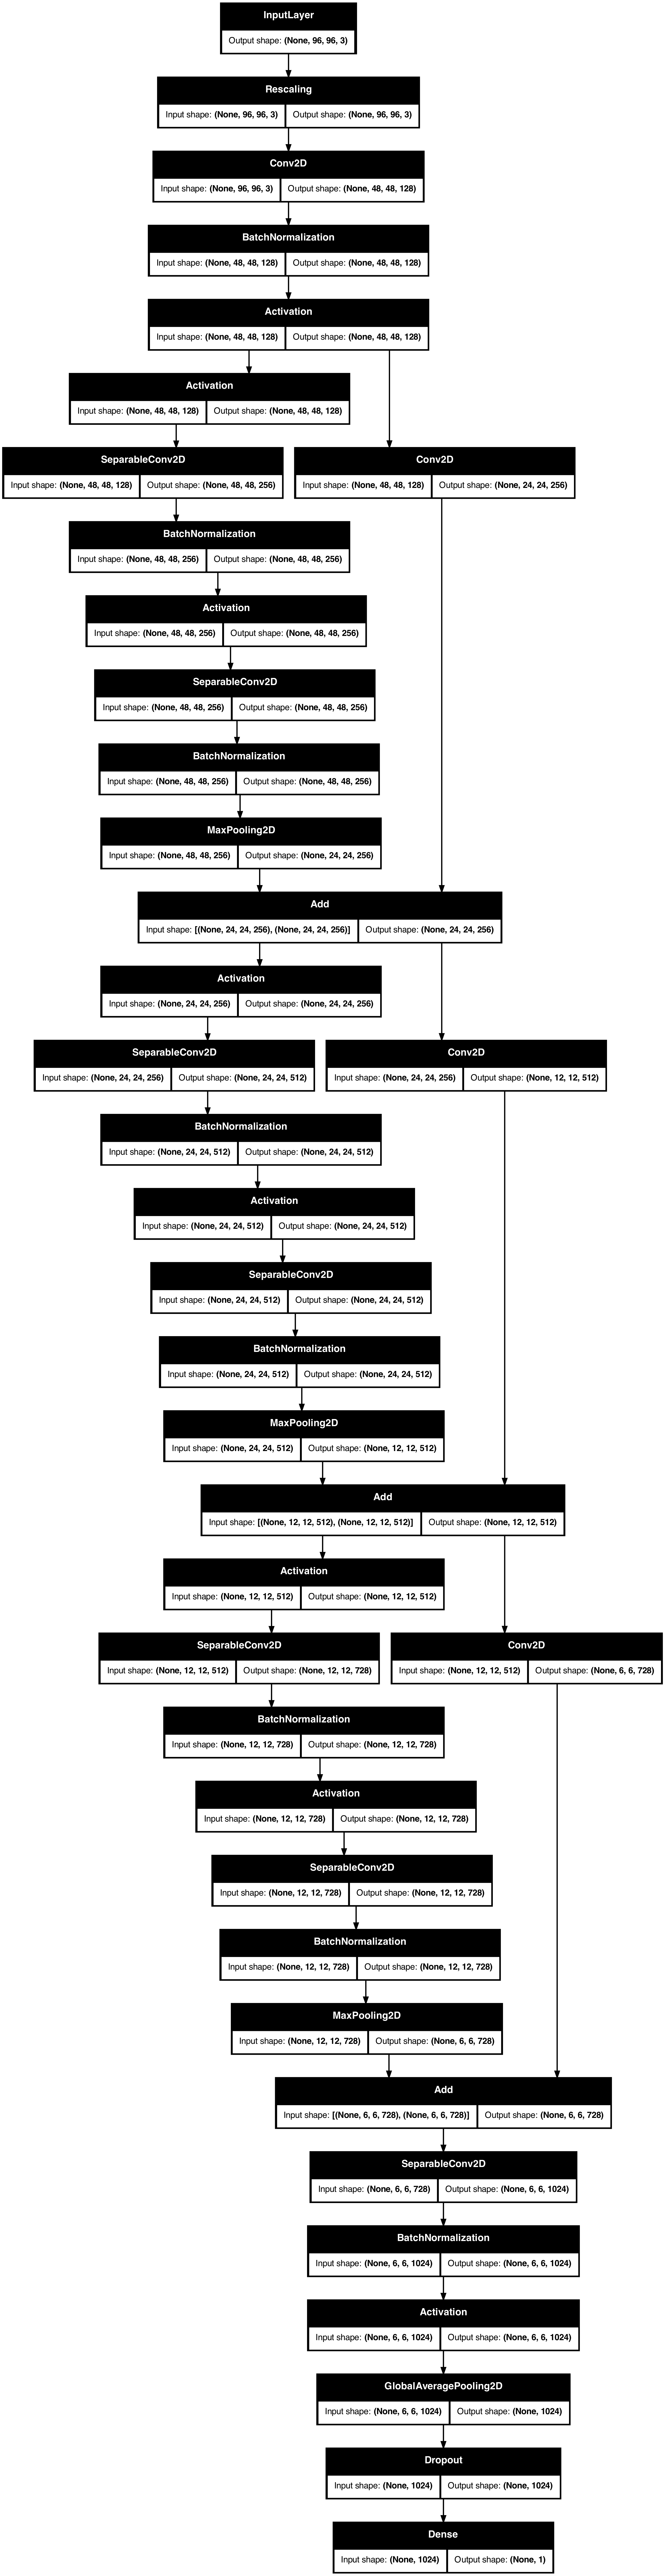

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


EPOCHS = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.keras"),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

# Class weights
labels = df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}



# Train custom CNN
history_custom = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/25


2025-07-22 19:29:07.101611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [ ]:
# Predict
test_ids = [f[:-4] for f in os.listdir(test_processed_dir) if f.endswith('.jpg')]
predictions = model.predict(test_ds).flatten()
submission = pd.DataFrame({'id': test_ids, 'label': (predictions > 0.5).astype(int)})
submission.to_csv('submission.csv', index=False)